In [6]:
# importing libraries
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import eig
import os
from PIL import Image as pim
import random

In [142]:
# Creating an array to store input dataset
# 400 Images
# 112*92 image dimension
dataset = np.ndarray(shape=(400,112,92),dtype=np.float64)

# loading the input dataset (data extracted to "dataset1" folder)
for i in range(40):                                                        # 40 faces
    for j in range(10):                                                    # 10 expressions each
        image = plt.imread("dataset1/s"+str(i+1)+"/"+str(j+1)+".pgm")
        dataset[10*i+j,:,:] = image

In [143]:
# Splitting the input dataset(400 images) to training set 60%(240) and testing set 40%(160)
train_set = np.ndarray(shape=(240,112,92), dtype = np.float64)
test_set  = np.ndarray(shape=(160,112,92), dtype = np.float64)
k, l = 0, 0
for i in range(400):                              # for every face
    if(i%10<6):                                   # 6 expression to train_set
        train_set[k,:,:] = dataset[i,:,:]
        k+=1
    else:                                         # 4 expressions to test_set
        test_set[l,:,:] = dataset[i,:,:]
        l+=1

In [144]:
# calculating the mean image of training set
mean = np.zeros(shape=(112,92),dtype=np.float64)
for i in range(240):
    for j in range(112):
        for k in range(92):
            mean[j][k]+=train_set[i][j][k]
mean = mean/240

In [145]:
# calculating mean zero matrix (substracting mean image from every image)
mean_aligned_face = np.ndarray(shape=(112*92,240),dtype=np.float64)
for i in range(240):
    for j in range(112*92):
        mean_aligned_face[j][i]= (train_set[i][int(j/92)][j%92]-mean[int(j/92)][j%92])

In [146]:
# calculating co-variance matrix
cov_mat = np.zeros(shape=(240,240), dtype=np.float64)
cov_mat = np.matmul(mean_aligned_face.T,mean_aligned_face)
cov_mat = cov_mat/(112*92)

In [147]:
# calculating eigenvalues and eigenvectors
eigenvalues, eigenvectors = eig(cov_mat)

In [148]:
K=[]
for i in range(1,28):         # taking a range of 0-28 based on the eigenvalues
    K.append(i)               # assigning 1 to 27 values to k
accuracy=[]                   # to store prediction accuracy for each k

for k in K:
    
    # feature vector with K eigen vectors
    feature_vector = eigenvectors[:,:k]

    # calculating eigen faces
    eigen_faces = np.matmul(feature_vector.T,mean_aligned_face.T)
    
    # calculating signature of each face
    eigen_signature = np.matmul(eigen_faces,mean_aligned_face)

    # -------------------------TESTING PART-------------------------------
    
    # calculating mean zero matrix of testing set
    test_mean_aligned = np.ndarray(shape=(112*92,160),dtype=np.float64)
    for i in range(160):
        for j in range(112*92):
            test_mean_aligned[j][i]= (test_set[i][int(j/92)][j%92]-mean[int(j/92)][j%92])

    # projecting mean aligned faces on eigen faces to get projected test faces
    projected_test_faces = np.matmul(eigen_faces,test_mean_aligned)

    crct = 0                                       # to count no of correct predictions
    
    for i in range(160):
        for j in range(240):
            euc_dist = np.sqrt(np.sum((projected_test_faces[:,i].T-eigen_signature[:,j].T)**2))  # calculating euclidean distance
            if(j==0):
                min_euc_dist = euc_dist
                index = j
            else:
                if min_euc_dist > euc_dist:                                                      
                    min_euc_dist = euc_dist                                                      # storing min_euclidean_distance
                    index = j                                                                    # and its index

        if int(i/4) == int(index/6):                                                             # if predicted face is true
            crct+=1                                                                              # increasing crct count by 1
    
    # storing accuracy of prediction for each k value
    accuracy.append(crct/160)

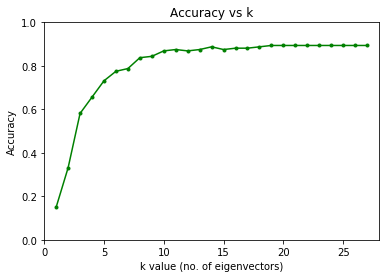

In [149]:
# plotting Accuracy vs k value
plt.plot(K,accuracy,'.g-')
plt.xlabel('k value (no. of eigenvectors)')
plt.ylabel('Accuracy')
plt.xlim(0,28)                                 
plt.ylim(0,1)
plt.title('Accuracy vs k')
plt.show()

# from the plot it is clear that from k = 19 the accuracy is not changing

In [150]:
# --------------------part -b -> FINDING IMPOSTERS-----------------

# converting some imposter faces located in imposters folder to grayscale
i=1
path1 = 'imposters/'
for file in os.listdir(path1):                                                  # reading all imposter faces
    img = pim.open(path1+file).convert('L')                                     # converting and saving the
    plt.imsave('Grayscale_imposters/imposter'+str(i)+'.pgm',img,cmap='gray')    # image as grayscale images
    i+=1

In [151]:
# adding grayscale imposter faces to testing data at random locations
path1 = 'Grayscale_imposters/'
positions = {}
for i in range(10):
    j = random.randint(1,159)                                 # generating random integers
    img = plt.imread(path1+'imposter'+str(i+1)+'.pgm')
    test_set[j,:,:] = img[:,:,0]                              # inserting at the random locations
    positions[j]=path1+'imposter'+str(i+1)+'.pgm'             # storing the positions of imposter faces

In [153]:
# since k = 19 gives maximum accuracy
K=[19]
for k in K:

    # feature vector with K eigen vectors
    feature_vector = eigenvectors[:,:k]

    # calculating eigen faces
    eigen_faces = np.matmul(feature_vector.T,mean_aligned_face.T)

    # calculating signature of each face
    eigen_signature = np.matmul(eigen_faces,mean_aligned_face)

    # calculating mean zero matrix of testing set
    test_mean_aligned = np.ndarray(shape=(112*92,160),dtype=np.float64)

    for i in range(160):
        for j in range(112*92):
            test_mean_aligned[j][i] = test_set[i][int(j/92)][j%92] - mean[int(j/92)][j%92]

    # projecting mean aligned faces on eigen faces to get projected test faces
    projected_test_faces = np.matmul(eigen_faces,test_mean_aligned)

    # To store average of euclidean_distances for every test face
    avg_euc_distances = {}
    
    for i in range(160):
        euc_dist = 0
        for j in range(240):
            euc_dist += np.sqrt(np.sum((projected_test_faces[:,i].T-eigen_signature[:,j].T)**2))  # calculating euclidean distance

        avg_euc_distances[euc_dist/160] = i                                                       # storing avg_euc_distances
    
    cnt = 0                                                                                       # to count no of imposters
    for i in sorted(avg_euc_distances.keys(),reverse=True)[:10]:
        if avg_euc_distances[i] in positions:
            print('found - ',positions[avg_euc_distances[i]])
            cnt+=1
    print('\nimposter finding accuracy -> ',cnt/10)                                     # printing accuracy of imposter finding
    
    # This accuracy value varies based on the random insertion of the imposter faces

found -  Grayscale_imposters/imposter1.pgm
found -  Grayscale_imposters/imposter8.pgm
found -  Grayscale_imposters/imposter9.pgm
found -  Grayscale_imposters/imposter10.pgm
found -  Grayscale_imposters/imposter7.pgm
found -  Grayscale_imposters/imposter4.pgm
found -  Grayscale_imposters/imposter2.pgm

imposter finding accuracy ->  0.7


In [4]:
a=np.zeros(shape=(4),dtype=np.float64)
b=np.ones(shape=(4),dtype=np.float64)
a=abs(a-b)
a

array([ 1.,  1.,  1.,  1.])

In [14]:
a=[[[i for i in range(3)] for j in range(10)] for k in range(10)]

In [15]:
plt.imshow(a)

In [16]:
plt.show()

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64